# Aнализ гипотез для увеличения выручки крупного интернет-магазина

Вместе с отделом маркетинга крупного интернет-магазина вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

**Описание данных**

В файле `/datasets/hypothesis.csv` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Файл `/datasets/hypothesis.csv`:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

В файлах `/datasets/orders.csv` и `/datasets/visitors.csv`результаты A/B-теста.

Файл `/datasets/orders.csv`:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Изучение данных

### 1.1 Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats
import numpy as np

pd.set_option('display.max_colwidth', None)

In [2]:
hypothesis = pd.read_csv ('/datasets/hypothesis.csv')
orders = pd.read_csv ('/datasets/orders.csv')
visitors = pd.read_csv ('/datasets/visitors.csv')

### 1.2 Информация о датафрейме hypothesis

In [3]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Датафрейм hypothesis содержит 9 гипотез по увеличению выручки интернет-магазина с параметрами Reach, Impact, Confidence, Effort. Столбцы названы корректно, объем данных полный.

### 1.3 Информация о датафрейме orders

In [5]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
orders.nunique()

transactionId    1197
visitorId        1031
date               31
revenue           713
group               2
dtype: int64

Датафрейм orders содержит 1197 строк с даннными о индификаторах заказа, пользователя, датой совершения заказа, выручкой и группой A/B теста. Столбцы названы корректно, объем данных полный. Необходимо привести формат даты object к типу даты pandas.

In [8]:
# приведение столбца date к типу даты pandas
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

In [9]:
#проверка попадания пользователей одновременно в две группы
group_counts = orders.groupby('visitorId')['group'].nunique()
users_in_both_groups = group_counts[group_counts > 1].count()
users_in_both_groups

58

In [10]:
count = 58/1031
count*100

5.625606207565471

58 пользователей одновременно оказались в двух группах. Эти пользователи составляют 5,6% от всех пользователей. Исключим их из дальнейшего анализа.

In [11]:
users_in_both_groups = orders.groupby('visitorId')['group'].nunique()
users_in_both_groups = users_in_both_groups[users_in_both_groups > 1].index.tolist()

In [12]:
#исключение пользователей, которые оказались в обоих группах
orders = orders.query('visitorId not in @users_in_both_groups')

In [13]:
orders.nunique()

transactionId    1016
visitorId         973
date               31
revenue           631
group               2
dtype: int64

Осталось 973 пользователя в разных группах.

### 1.4 Информация о датафрейме visitors

In [14]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [15]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Датафрейм visitors содержит 62 строки с датой, группой A/B теста и кол-вом пользователей. Столбцы названы корректно, объем данных полный. Необходимо привести формат даты object к типу даты pandas. 

In [16]:
# приведение столбца date к типу даты pandas
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

## 2 Приоритизация гипотез

### 2.1 Фреймворк ICE для приоритизации гипотез по убыванию приоритета

In [17]:
hypothesis['ICE'] = (hypothesis['Impact'] * hypothesis['Confidence'])/hypothesis['Efforts']
hypothesis[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False).round(3)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


К перспективным гипотезам по ICE относятся:

1. Запустить акцию, дающую скидку на товар в день рождения.

2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

### 2.2 Фреймворк RICE для приоритизации гипотез по убыванию приоритета

In [18]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'])/hypothesis['Efforts']
hypothesis[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


К перспективным гипотезам по RICE относятся:

1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.

3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

ICE и RICE распределили приоритетность гипотез в разных последовательностях за счет того, что в расчете ICE используются 3 компонента - влияние, уверенность, усилия. А в RICE добавляется 4-ый компонент - охват. 

## 3 Анализ A/B-теста

### 3.1 Построение графика кумулятивной выручки по группам

In [19]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [20]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date' : 'max', 
             'group' : 'max', 
             'transactionId' : 'nunique', 
             'visitorId' : 'nunique', 
             'revenue' : 'sum'
        }
    ),
    axis=1
).sort_values(by=['date','group'])

In [21]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group'])
    ].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), 
    axis=1).sort_values(by=['date','group'])

In [22]:
ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [23]:
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [24]:
# объединяем кумулятивные данные в одной таблице
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


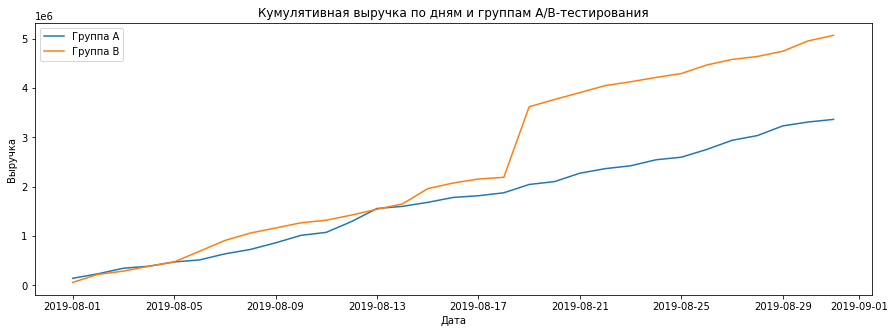

In [25]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

#зададим размеры графика 
plt.figure(figsize=(15,5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()

# зададим описание графика
plt.legend(['Группа А', 'Группа B']) 
plt.xlabel('Дата')
plt.ylabel('Выручка') 
plt.title('Кумулятивная выручка по дням и группам A/B-тестирования')
plt.show() 

Кумулятивная выручка почти равномерно увеличивается в течение всего теста.
Однако график выручки группы В в середине теста резко вырос. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 

 ### 3.2 Построение графика кумулятивного среднего чека по группам

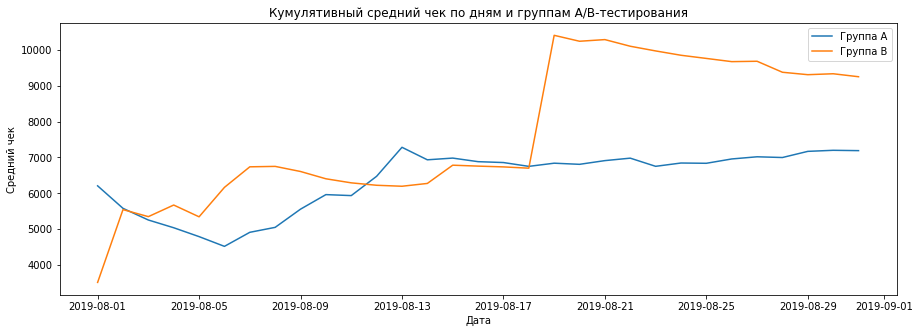

In [26]:
#зададим размеры графика 
plt.figure(figsize=(15,5))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()

# зададим описание графика
plt.legend(['Группа А', 'Группа B']) 
plt.xlabel('Дата')
plt.ylabel('Cредний чек') 
plt.title('Кумулятивный средний чек по дням и группам A/B-тестирования')
plt.show() 

Кумулятивный средний чек группы А сначала снижается, но потом растет и становится стабильным.
Средний чек группы В резко вырос в точке, как и выручка. Но затем он уменьшался.

 ### 3.3 Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

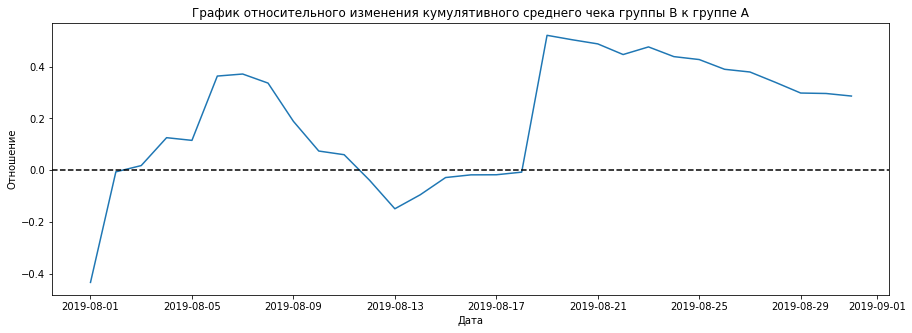

In [27]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

#зададим размеры графика 
plt.figure(figsize=(15,5))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

# зададим описание графика
plt.xlabel('Дата')
plt.ylabel('Отношение') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show() 

На графике относительного изменения кумулятивного среднего чека группы B к группе A есть резкие скачки, это может значит, что именно в пиковый день на графике, были сделаны крупные заказы.

### 3.4 Построение графика кумулятивного среднего количества заказов на посетителя по группам

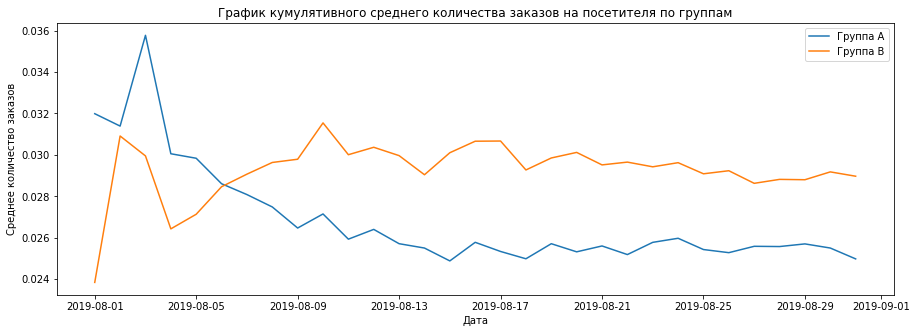

In [28]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

#зададим размеры графика 
plt.figure(figsize=(15,5))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# зададим описание графика
plt.legend(['Группа А', 'Группа B']) 
plt.xlabel('Дата')
plt.ylabel('Cреднее количество заказов') 
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.show() 

Кумулятивное среднее количество заказов у группы В вначале было выше, чем у группы А, но затем опустилось вниз и продолжило колебалаться внизу. У группы А кол-во заказов вначале колебалось, затем стало больше, чем у группы В.

Вначале данные сильно колебались у обоих групп, но затем кол-во заказов группы B выросло и далее зафиксировалась, а конверсия группы A упала относительно первоначальных значений и тоже зафиксировалась. 

### 3.5 Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A 

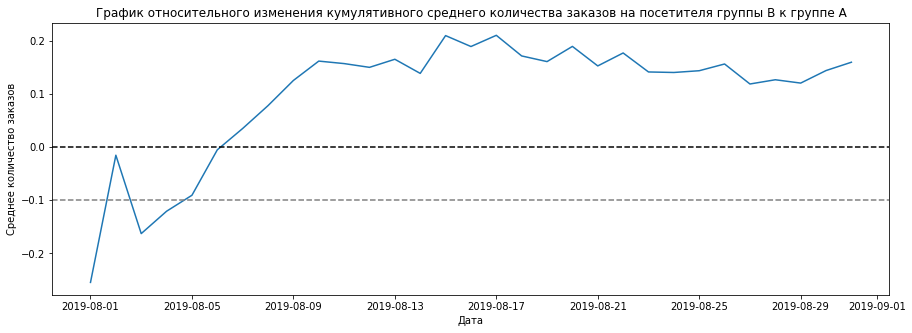

In [29]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

#зададим размеры графика 
plt.figure(figsize=(15,5))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
         mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

# зададим описание графика
plt.xlabel('Дата')
plt.ylabel('Cреднее количество заказов') 
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.show() 

Среднее количество заказов на посетителя для группы B сначало было меньше, чем у группы А, нозатем значительно обогнало ее.

### 3.6 Построение точечного графика количества заказов по пользователям

In [30]:
ordersByUsers = (orders.drop(['group', 'revenue', 'date'], axis=1).
                 groupby('visitorId', as_index=False).
                 agg({'transactionId' : pd.Series.nunique}))

ordersByUsers.sort_values(by='transactionId',ascending=False)

,visitorId,transactionId
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
...,...,...
331,1438226485,1
332,1452540367,1
333,1455323168,1
334,1455861274,1


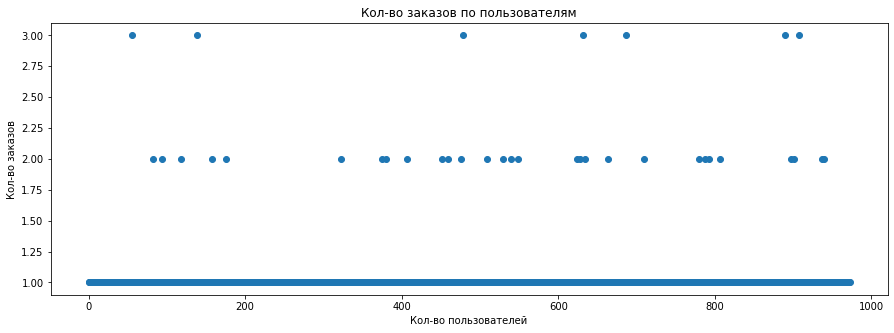

In [31]:
x_values = pd.Series(range(0,len(ordersByUsers['transactionId'])))
plt.figure(figsize=(15,5)) 
plt.scatter(x_values, ordersByUsers['transactionId']) 
# зададим описание графика 
plt.ylabel('Кол-во заказов') 
plt.xlabel('Кол-во пользователей') 
plt.title('Кол-во заказов по пользователям') 
plt.show() 

Большинство пользователей совершали только 1 заказ. Меньшее кол-во тех, кто совершил 2-3 заказа. 

### 3.7 Подсчёт 95-ого и 99-ого перцентилей количества заказов на пользователя. 

In [32]:
print(np.percentile(ordersByUsers['transactionId'], [95, 99]))

[1. 2.]


Не более 5% пользователей совершили больше 1 заказов, а не более 1% совершили больше 2 заказов. Более 2 заказов является аномальной границей.

### 3.8 Построение точечного графика стоимостей заказов

In [33]:
orders[['visitorId', 'revenue']].sort_values(by='revenue', ascending=False)

,visitorId,revenue
425,1920142716,1294500
1196,2108080724,202740
1136,1307669133,92550
744,888512513,86620
743,4133034833,67990
...,...,...
404,1995481842,70
933,3577713868,60
584,2705308997,50
756,3423937755,50


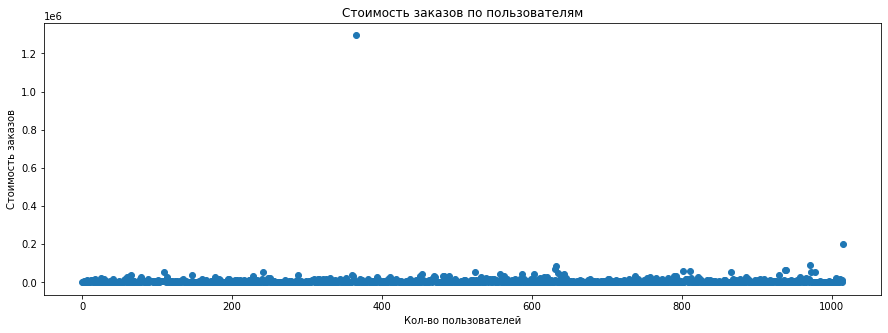

In [34]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,5)) 
plt.scatter(x_values, orders['revenue']) 

# зададим описание графика 
plt.ylabel('Стоимость заказов') 
plt.xlabel('Кол-во пользователей') 
plt.title('Стоимость заказов по пользователям') 
plt.show() 

Сумма заказов 1,29 млн намного больше, чем стоимость остальных заказов. Постоим график без данного значения.

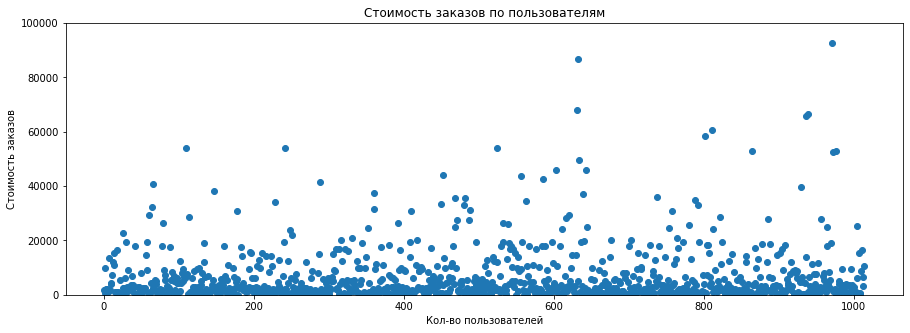

In [35]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,5)) 
plt.scatter(x_values, orders['revenue']) 
#срежем очевидно анамальные заказы 
plt.ylim(0, 100000)
# зададим описание графика 
plt.ylabel('Стоимость заказов') 
plt.xlabel('Кол-во пользователей') 
plt.title('Стоимость заказов по пользователям') 
plt.show() 

Большинство заказов стоимостью до 20 тыс.

### 3.9 Подсчёт 95-ого и 99-ого перцентилей стоимости заказов

In [36]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более 5% пользователей совершили заказов на сумму 26,7 тыс., а не более 1% совершили больше заказов на сумму 53,9 тыс. Стоимость заказов более 30 тыс. является аномальной границей.

### 3.10 Подсчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем гипотезы:

Нулевая: различий в среднем количестве заказов на посетителя между группами нет. 

Альтернативная: различия в среднем между группами есть.

Статистический критерий проверки гипотез Манна-Уитни.
    
Уровень статистической значимости α = 0.05
  

In [37]:
# изучим код и устройство таблицы data:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Названия столбцов данных:

- `date` — дата;
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
- `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

In [38]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

In [39]:
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(
                         data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(
                         data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [40]:
print('p-value =', '{0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительное различие в среднем количестве заказов на посетителя между группами по «сырым» данным:',
      '{0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))


p-value = 0.011
Относительное различие в среднем количестве заказов на посетителя между группами по «сырым» данным: 0.160


P-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов на посетителя между группами по «сырым» данным нет, отвергаем.  

Относительный выигрыш группы B равен 16%.

### 3.11 Подсчёт статистической значимости различий в среднем чеке  заказа между группами по «сырым» данным

Сформулируем гипотезы:

Нулевая: различий в среднем чеке заказа между группами нет.

Альтернативная: различия в среднем между группами есть.

In [41]:
print('p-value =', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие в среднем чеке между группами по «сырым» данным:',
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.829
Относительное различие в среднем чеке между группами по «сырым» данным: 0.287


P-value = 0.829, это больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке заказа между группами по «сырым» данным есть различия, нет. 

Средний чек группы В сильно больше среднего чека группы А на 28,7%.

### 3.12 Подсчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [42]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
928     204675465
33      249864742
684     358944393
648     382846391
Name: visitorId, dtype: int64
49


Всего 57 аномальных пользователей. 

Сформулируем гипотезы:

Нулевая: различий в среднем количестве заказов на посетителя между группами нет.

Альтернативная: различия в среднем между группами есть.

In [43]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value =', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное различие в в среднем количестве заказов на посетителя между группами по «очищенным» данным:', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value = 0.010
Относительное различие в в среднем количестве заказов на посетителя между группами по «очищенным» данным: 0.187


Результаты по среднему количеству заказов практически не изменились.

### 3.13 Подсчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезы:

Нулевая: различий в среднем чеке заказа между группами нет.

Альтернативная: различия в среднем между группами есть.

In [44]:
print(
    'p-value =',
      '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительное различие в среднем чеке между группами по «очищенным» данным:',
      '{0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.741
Относительное различие в среднем чеке между группами по «очищенным» данным: -0.027


P-value больше 0,5. Причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Однако по «очищенным» данным средний чек группы А больше среднего чека группы В. По «сырым» данным было наоборот.

## 4 Общий вывод

В ходе исследования была изучена общая информация о данных и проанализированы гипотезы для увеличения выручки крупного интернет-магазина.

По результатам обзора и подготовки данных определено, что данные предствлены в полном обьеме,отсутсвуют пропущенные значения и дубликаты, формат столбца date переведен с типа object на datetime.

В ходе исследовательской работы была выполненена приоритезация гипотез с помощью фреймворков ICE и RICE. ICE и RICE распределили приоритетность гипотез в разных последовательностях за счет того, что в расчете ICE используются 3 компонента - влияние, уверенность, усилия. А в RICE добавляется 4-ый компонент - охват, который влияет на изменение ранжирования.

К перспективным гипотезам по ICE относятся:
- Запустить акцию, дающую скидку на товар в день рождения.
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

К перспективным гипотезам по RICE относятся:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

Результаты анализа A/B-теста показали:
- Кумулятивная выручка групп А и В увеличивается в течение всего теста. Однако график выручки группы В выше и в середине теста показал резкий скачок. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.
- Кумулятивный средний чек группы А сначала снижается, но потом растет и становится более стабильным, оставаясь ниже, чем у группы В. Средний чек группы В резко вырос в середине теста, как и выручка, но затем уменьшался.
- Кумулятивное среднее количество заказов у группы В вначале было выше, чем у группы А, но затем опустилось вниз и продолжило колебалаться внизу. У группы А кол-во заказов вначале колебалось ниже, затем стало выше, чем у группы В. 
- Не более 5% пользователей совершили больше 1 заказов, а не более 1% совершили больше 2 заказов. Более 2 заказов является аномальной границей.
- Не более 5% пользователей совершили заказов на сумму 26,7 тыс., а не более 1% совершили больше заказов на сумму 53,9 тыс.Стоимость заказов более 30 тыс. является аномальной границей. В группе  был сдеалн один аномально большой заказ на сумму 128 млн руб.

- Есть различия в среднем количестве заказов на посетителя между группами А и В по «сырым» и «очищенным» данным. По «сырым» данным относительный выигрыш группы B равен 16%, а по «очищенным» 18,7%.
- Нет  статистически значимых различий в среднем чеке заказа между группами А и В по «сырым» и «очищенным» данным. По «сырым» данным средний чек группы В выше среднего чека группы А на 28,7%, а по «очищенным» - наоборот средний чек группы А больше среднего чека группы В.

В результате, тест можно остановить и зафиксировать победу группы В. Несмотря на то, что средний чек группы В по «очищенным» данным ниже, кумулятивный средний чек группы В выше. Среднее количество заказов на посетителя также выше у группы В, но лишь на 2,7%. 